# Multivariate Time Series Forecasting of PM 2.5 levels in China using LSTM

The five datasets contain multiple variables, and our goal is to predict the number of days of high PM 2.5 levels per month in each city. Thus Long Short-Term Memory (LSTM) is used in this data challenge as LSTM has shown its efficiency in time series forecasting.

If you have any question, contact yupinglu89@gmail.com (Yuping Lu)

### 1. Loading the libraries

In [1]:
#import libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM

beijing = 'FiveCitiesPMData/BeijingPM20100101_20151231.csv'

### 2. Data Preprocessing

The function below is to read a file and replace the missing values with 0. In this data challenge, I use data from Beijing as it contains more information (other files have more missing values).

In [2]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

def dataReader(fname):
    dataset = pd.read_csv(fname, index_col=0, date_parser=parse, parse_dates=[['year', 'month', 'day', 'hour']])
    # remove columns
    dataset.drop('No', axis=1, inplace=True)
    dataset.drop('season', axis=1, inplace=True)
    # replace missing values with 0
    dataset['cbwd'].fillna('NW', inplace=True)
    dataset.fillna(0, inplace=True)

    return dataset                           

In [3]:
df = dataReader(beijing)
# the first day contains no pm2.5 values, so we remove those entries.
df = df[24:]

Check the column names.

In [4]:
df.columns

Index(['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US Post', 'DEWP',
       'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec'],
      dtype='object')

Get a glimpse of the data.

In [5]:
df.head()

,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
year_month_day_hour,,,,,,,,,,,,
2010-01-02 00:00:00,0.0,0.0,0.0,148.0,-16.0,38.0,1020.0,-4.0,SE,1.79,0.0,0.0
2010-01-02 01:00:00,0.0,0.0,0.0,159.0,-15.0,42.0,1020.0,-4.0,SE,2.68,0.0,0.0
2010-01-02 02:00:00,0.0,0.0,0.0,181.0,-11.0,63.5,1021.0,-5.0,SE,3.57,0.0,0.0
2010-01-02 03:00:00,0.0,0.0,0.0,138.0,-7.0,85.0,1022.0,-5.0,SE,5.36,0.0,0.0
2010-01-02 04:00:00,0.0,0.0,0.0,109.0,-7.0,85.0,1022.0,-5.0,SE,6.25,0.0,0.0


Plot each colum. 'PM_US Post' column contains more valid entries, thus I removed the other three pm 2.5 columns. I also noticed 'precipitation' and 'Iprec' have outliers. So I replaced those outliers with 0.

In [6]:
# specify columns to plot
def vizCol(groups, dataset):
    i = 1
    # plot each column
    plt.figure(figsize=(18,12))
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(dataset.values[:, group])
        plt.title(dataset.columns[group], y=0.5, loc='right')
        i += 1
    plt.show()

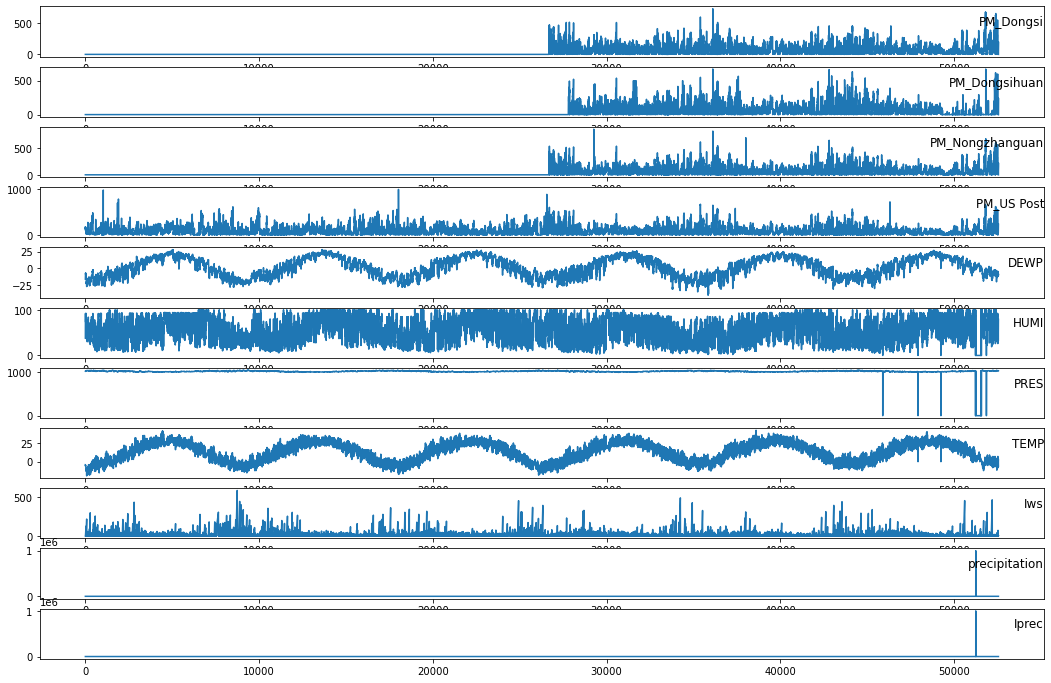

In [7]:
groups = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]
vizCol(groups, df)

In [8]:
print(max(df.values[:, 10]))
print(max(df.values[:, 11]))

999990.0
999990.0


In [9]:
df.loc[df['precipitation'] == 999990.0, 'precipitation'] = 0
df.loc[df['Iprec'] == 999990.0, 'Iprec'] = 0
df.drop(['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan'], axis=1, inplace=True)

The figure below looks better now.

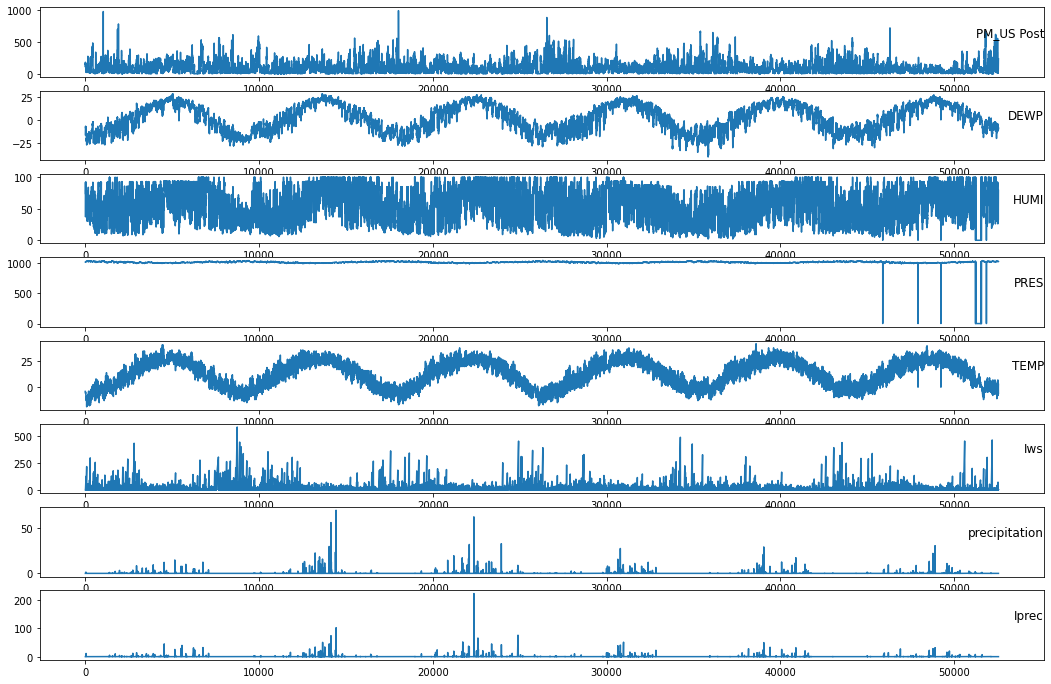

In [10]:
groups = [0, 1, 2, 3, 4, 6, 7, 8]
vizCol(groups, df)

'cbwd' column contains categorical values, thus we need to convert those values to numbers.

In [11]:
# encode the categorical values
values = df.values
encoder = LabelEncoder()
values[:,5] = encoder.fit_transform(values[:,5])
values = values.astype('float32')
values[:,5]

# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)
print(scaled_dataset.shape)

(52560, 9)


Add label to the data, here we choose window size 4.

In [12]:
# add label to the data
def addLabel(train):
    window_size = 4
    X = []
    Y = []
    for i in range(window_size, len(train)):
        X.append(train[i-window_size:i,:])
        Y.append(train[i,0:1])
    return X,Y

In [13]:
X, Y = addLabel(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (52556, 1)
X (52556, 4, 9)


Prepare training set and test set. To save time, I picked the first year's data as training set and the rest as test set

In [14]:
# splitting the dataset
n_train = 24*365
X_train, X_test = X[:n_train,] , X[n_train:,]
print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)

Y_train, Y_test = Y[:n_train,] , Y[n_train:,]
print('Y_train' ,Y_train.shape)
print('Y_test' ,Y_test.shape)

X_train (8760, 4, 9)
X_test (43796, 4, 9)
Y_train (8760, 1)
Y_test (43796, 1)


### 3. LSTM model and training

In [15]:
# design the LSTM model
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')   

The figure below shows the training process. The result looks good, no overfitting or underfitting. Here I only used 50 epochs to save time.

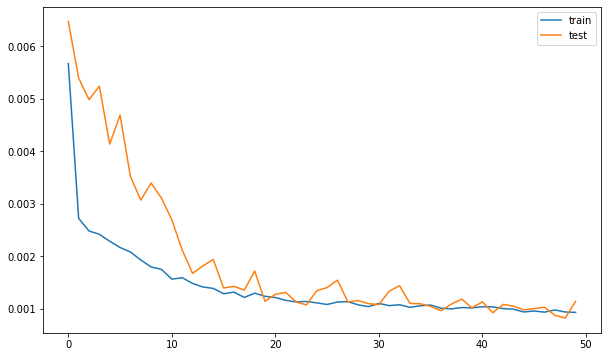

In [16]:
# train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_test, Y_test), verbose=0, shuffle=False)
# plot history
plt.figure(figsize=(10,6)) 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 4. Model evaluation

In [17]:
# make a prediction
Y_pred = model.predict(X_test)
# invert scaling
Y_predicted = np.concatenate((Y_pred, scaled_dataset[n_train+4:,1:]), axis =1)
Y_tested = np.concatenate((Y_test, scaled_dataset[n_train+4:,1:]), axis = 1)
Y_predicted = scaler.inverse_transform(Y_predicted)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
print('Y_tested', Y_tested.shape)
print('Y_predicted', Y_predicted.shape)
mse = mean_squared_error(Y_tested, Y_predicted)
print('RMSE' , np.sqrt(mse))

Y_tested (43796, 1)
Y_predicted (43796, 1)
RMSE 33.58638


Here we used year 2015's data to evaluate our model. Our predicted values are very close to the actual values.

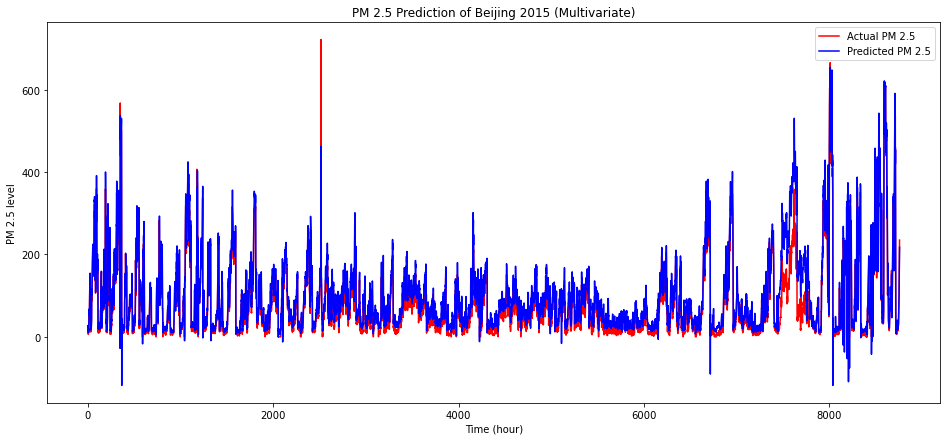

In [19]:
# plot a graph of actual vs predicted values
cut = 365*24
plt.figure(figsize=(16,7))  
plt.plot(Y_tested[-cut:,:] , color = 'red',label = 'Actual PM 2.5')
plt.plot(Y_predicted[-cut:,:], color= 'blue',label = 'Predicted PM 2.5')
plt.title("PM 2.5 Prediction of Beijing 2015 (Multivariate)")
plt.xlabel("Time (hour)")
plt.ylabel("PM 2.5 level")
plt.legend()
plt.show()

### 4. Unhealthy days of Beijing 2015

Lastly, we calculated the number of days of high PM 2.5 per month of Beijing 2015. Here, we set the PM 2.5 threshold as 100. As it turns out, Beijing has a serious air pollution problem.

In [20]:
def unhealthyDays(data):
    days = [0] * 365
    for i in range(len(data)):
        if(data[i] > 100):
            days[i // 24] = 1 
    month = [0]*12
    month[0] = sum(days[0:31])
    month[1] = sum(days[31:59])
    month[2] = sum(days[59:90])
    month[3] = sum(days[90:120])
    month[4] = sum(days[120:151])
    month[5] = sum(days[151:181])
    month[6] = sum(days[181:212])
    month[7] = sum(days[212:243])
    month[8] = sum(days[243:273])
    month[9] = sum(days[273:304])
    month[10] = sum(days[304:334])
    month[11] = sum(days[334:365])
    return month

No handles with labels found to put in legend.


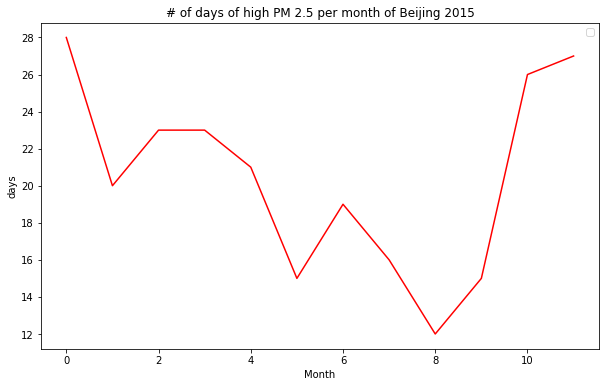

In [21]:
pm_beijing = unhealthyDays(Y_predicted[-cut:,:])
plt.figure(figsize=(10,6)) 
plt.plot(pm_beijing, color = 'red')
plt.title("# of days of high PM 2.5 per month of Beijing 2015")
plt.xlabel("Month")
plt.ylabel("days")
plt.legend()
plt.show()

### 5. Summary

In this data challenge, I presented a LSTM model to predict the PM 2.5 levels in Beijing. We could repeat the same process for the other four cities. LSTM is a very efficient model to handle time series forcasting problem. And the training takes only several minutes on my macbook. I used all the features available in the dataset to train our model. For future analysis, we could first analyze each feature and pick the most relevant features to train the model and also do more tuning to the LSTM model.